In [1]:
#Notebook for experiments in gathering data

In [2]:
import os
import re
import csv
import requests
import warnings
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm, tqdm_notebook
#warnings.filterwarnings('ignore')

In [71]:
male_directors_path = f"./raw_data/director_lists/wiki/male_directors_wiki_latinized_20190616.csv"
female_directors_path = f"./raw_data/director_lists/wiki/female_directors_wiki_latinized_20190616.csv"
male_directors_df = pd.read_csv(male_directors_path)
female_directors_df = pd.read_csv(female_directors_path)
print(len(male_directors_df), len(female_directors_df))

1772 1036


In [72]:
male_names = male_directors_df.name
female_names = female_directors_df.name

In [77]:
path = f"./raw_data/full_deadline_df.csv"
df = pd.read_csv(path)
df = df.drop(df.columns[0], axis=1)
df.head()

,media,article_url,text_path,category,content_type,topics,title,author,published_at,tags
0,deadline,https://deadline.com/2019/01/4-percent-challen...,deadline/0.txt,film,Article,Film,Universal Commits To Time's Up's #4PercentChal...,Patrick Hipes,2019-01-29 14:07:49,"#4PercentChallenge, Time's Up, Universal"
1,deadline,https://deadline.com/2019/03/jared-harris-jare...,deadline/1.txt,film,Article,Film,Jared Harris Joins Jared Leto In Sony's 'Spide...,Amanda N'Duka,2019-03-04 16:28:50,"Jared Harris, Morbius, Sony"
2,deadline,https://deadline.com/2019/03/sky-tin-star-tim-...,deadline/2.txt,film,Article,"Film, International, TV",Sky Orders Third Season Of 'Tin Star'; 42 Hire...,Andreas Wiseman,2019-03-20 04:09:15,"42, Tim Roth, Tin Star"
3,deadline,https://deadline.com/2019/02/jj-abrams-jedi-st...,deadline/3.txt,film,Article,"Film, Hero Nation",'Star Wars IX': The Last Skywalker Film Wraps ...,Geoff Boucher,2019-02-15 12:56:07,"Hero Nation, JJ Abrams, Lucasfilm, Star Wars"
4,deadline,https://deadline.com/2019/03/june-harding-dies...,deadline/4.txt,film,Article,"Film, TV",June Harding Dies: 'The Trouble With Angels' A...,Bruce Haring,2019-03-29 16:34:36,"Hayley Mills, Ida Lupino, June Harding, Obitua..."


In [106]:
def parse_year(str_date):
    return (int)(str_date[:4])

def valid_date(str_date):
    year = parse_year(str_date)
    if year >= 2008 and year <= 2018:
        return True
    else:
        return False;
    
def find_in(line, names):
    res = []
    for name in names:
        if name in line:
            res.append(name)
    return res    
    
def process(df, male_names, female_names):
    males = dict()
    females = dict()
    with tqdm(desc="rows", total=len(df)) as pbar_outer:    
        for row in df.itertuples():
            # check only required dates
            str_date = getattr(row, 'published_at')
            if not valid_date(str_date):
                continue
            # go through text to find directors
            year = parse_year(str_date)                
            text_path = getattr(row, 'text_path')
            for line in open(f'../modified_dfs/{text_path}'):
                # look up male names
                for name in find_in(line, male_names):
                    if year in males:
                        if name in males[year]:
                            males[year][name].append(text_path)                                 
                        else:
                            males[year][name] = [text_path]
                    else:
                        males[year] = {name : [text_path]}
                # look up female names        
                for name in find_in(line, female_names):
                    if year in females:
                        if name in females[year]:
                            females[year][name].append(text_path)                                                             
                        else:
                            females[year][name] = [text_path]
                    else:
                        females[year] = {name : [text_path]}    
            pbar_outer.update(1)            
    return males, females            

males, females = process(df, male_names, female_names)            

rows:  95%|█████████▌| 48639/51090 [10:48<00:32, 75.00it/s] 


In [110]:
f_out = open('./female_mention_per_year.txt', 'w')
for year, dct in females.items():    
    for name, articles in dct.items():
        res = str(year) + ' ' + name + ' '
        for item in articles:
            res += item + ' '
        res += '\n'   
        f_out.write(res)
f_out.close() 

In [111]:
f_out = open('./male_mention_per_year.txt', 'w')
for year, dct in males.items():    
    for name, articles in dct.items():
        res = str(year) + ' ' + name + ' '
        for item in articles:
            res += item + ' '
        res += '\n'   
        f_out.write(res)
f_out.close()

In [3]:
## load from disk and process
female_path = './female_mention_per_year.txt'
male_path = './male_mention_per_year.txt'

def stats(path):
    dct = dict()    
    # construct dict from saved data
    for line in open(path, 'r'):    
        lst = line.split()
        i = 0    
        
        # parse year
        year= lst[i]
        i = i + 1    
        # parse director`s name
        name = ''
        while lst[i][:8] != "deadline":
            if name != '':
                name += ' '
            name += lst[i]
            i = i + 1        
        # parse mentions
        mentions = set(lst[i:])
        mentions = len(mentions)
    
        # fill dict
        if year in dct:
            dct[year][name] = mentions
        else:
            dct[year] = {name : mentions}
    #####################################            
        
    # Calculate sorted years (x axis)
    years = []
    for key, value in dct.items():
        years.append(int(key))
    years.sort()
    print("x(years):", years)

    # Calculate mentions(x) -- number of articles per year
    mentions = []
    for x in years:
        total_x = 0
        for key, value in dct[str(x)].items():
            total_x += value
        mentions.append(total_x)
    print("y(mentions):", mentions)
    print('\n')
        
    # Calculate dict {name : fame}, where fame is number of mentions
    director_fame = dict()
    for x in years:
        for name, value in dct[str(x)].items():
            if name in director_fame:
                director_fame[name] += value
            else:
                director_fame[name] = value

    # Calculate directors list sorted by fame
    fame = []            
    for key, value in director_fame.items():
        fame.append((value, key))
    fame = sorted(fame, key=lambda x: (-x[0], x[1]))
    for x in fame:
        print(x)        

In [4]:
stats(female_path)

x(years): [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
y(mentions): [143, 669, 1019, 1157, 1065, 1185, 1393, 1662, 1810]


(489, 'Angelina Jolie')
(442, 'Natalie Portman')
(307, 'Kathryn Bigelow')
(304, 'Ava DuVernay')
(231, 'Jennifer Aniston')
(214, 'Jodie Foster')
(211, 'Jennifer Garner')
(193, 'Salma Hayek')
(163, 'Barbra Streisand')
(143, 'Dee Rees')
(134, 'Robin Wright')
(130, 'Lena Dunham')
(129, 'Patricia Arquette')
(127, 'Vera Farmiga')
(126, 'Sofia Coppola')
(122, 'Jennifer Jason Leigh')
(122, 'Sally Field')
(121, 'Diane Keaton')
(121, 'Patty Jenkins')
(104, 'Whoopi Goldberg')
(96, 'Susanne Bier')
(92, 'Lynne Ramsay')
(91, 'Helen Hunt')
(89, 'Drew Barrymore')
(88, 'Bryce Dallas Howard')
(83, 'Julie Delpy')
(82, 'Jane Campion')
(80, 'Kathy Bates')
(79, 'Andrea Arnold')
(75, 'Angela Bassett')
(72, 'Catherine Hardwicke')
(72, 'Nancy Meyers')
(69, 'Nadine Labaki')
(68, 'Debra Granik')
(65, 'Shonda Rhimes')
(62, 'Paula Patton')
(61, 'Lynn Shelton')
(59, 'Amma Asante')
(59

In [5]:
stats(male_path)

x(years): [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
y(mentions): [761, 4362, 6010, 6875, 6246, 6160, 6882, 7099, 6234]


(1329, 'Steven Spielberg')
(1152, 'McG')
(976, 'Martin Scorsese')
(954, 'Walt Disney')
(775, 'Tom Hanks')
(762, 'Ridley Scott')
(718, 'George Clooney')
(690, 'Ben Affleck')
(675, 'Johnny Depp')
(662, 'Clint Eastwood')
(640, 'Quentin Tarantino')
(626, 'Robert De Niro')
(552, 'Woody Allen')
(542, 'Ryan Gosling')
(541, 'Denzel Washington')
(537, 'Christopher Nolan')
(501, 'Robert Redford')
(468, 'Ron Howard')
(456, 'James Cameron')
(428, 'Mel Gibson')
(407, 'Peter Jackson')
(383, 'Richard Linklater')
(373, 'David Fincher')
(367, 'Michael Bay')
(360, 'Ang Lee')
(359, 'Steven Soderbergh')
(348, 'Tim Burton')
(329, 'Damien Chazelle')
(327, 'Spike Lee')
(323, 'Darren Aronofsky')
(306, 'Keanu Reeves')
(306, 'Sylvester Stallone')
(305, 'Morgan Freeman')
(305, 'Oliver Stone')
(302, 'Stephen King')
(299, 'Luc Besson')
(288, 'Wes Anderson')
(287, 'Sean Penn')
(285, 

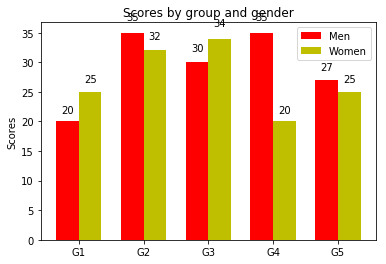

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

N = 5
men_means = (20, 35, 30, 35, 27)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, men_means, width, color='r')

women_means = (25, 32, 34, 20, 25)
rects2 = ax.bar(ind + width, women_means, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()